According to the results presented in our paper, DreaMS embeddings provide a more accurate way to perform library matching than traditional algorithms such as modified cosine similarity or spectral entropy. Library matching is the annotation of a query spectrum with a molecule corresponding to the most similar spectrum in some given spectral library. In this tutorial, we will demonstrate how to perform library matching with DreaMS embeddings using the MassSpecGym dataset as a library, which contains a curated collection of public high-quality MS/MS spectra.

In [1]:
import sys
from pathlib import Path

# assume this notebook lives in notebooks/, so parent() is the repo root
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

import numpy as np
import pandas as pd
from tqdm import tqdm

from dreams.utils.data import MSData
from dreams.api import dreams_embeddings
from sklearn.metrics.pairwise import cosine_similarity
import dreams.utils.spectra as su

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


### We will use data from our previous tutorial, so deduplicated, positive and high quality

In [2]:
# 1) Define paths ----------------------------------------------------------
# 1a) MassSpecGym library
mgf_path      = PROJECT_ROOT / "data" / "massspecgym" / "MassSpecGym.mgf"
lib_h5        = mgf_path.with_suffix(".hdf5")
lib_emb_path  = lib_h5.with_name(lib_h5.stem + "_dreams_emb.npy")

# 1b) Our query: deduplicated, high-quality spectra from step 2
query_h5       = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated_high_quality_dedup.hdf5"
query_emb_path = query_h5.with_name(query_h5.stem + "_dreams_emb.npy")

In [3]:
# 1c) Results folder
results_folder = PROJECT_ROOT / "results"
results_folder.mkdir(exist_ok=True)

### DreaMS needs at the input mass spectra and precursor mz

#### Furher if you do not have embeddings computed for MassSpecGym, it will now compute, it can take approximatelly one hour but after that you can reuse it, and it is done in no time then.

In [4]:
# 2) Load MassSpecGym library (or convert if needed) -----------------------
if lib_h5.exists():
    msdata_lib = MSData.from_hdf5(lib_h5, in_mem=True)
else:
    # parse .mgf → .hdf5
    msdata_lib = MSData.load(
        mgf_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ")
print(f"Library loaded: {len(msdata_lib)} spectra → {lib_h5.name}")
print("Columns:", msdata_lib.columns())

Loading dataset MassSpecGym into memory (231104 spectra)...
Library loaded: 231104 spectra → MassSpecGym.hdf5
Columns: ['COLLISION_ENERGY', 'FOLD', 'FORMULA', 'IDENTIFIER', 'INCHIKEY', 'INSTRUMENT_TYPE', 'PARENT_MASS', 'PRECURSOR_FORMULA', 'SIMULATION_CHALLENGE', 'adduct', 'precursor_mz', 'smiles', 'spectrum']


### Now we will compute embeddings for our investigated data

In [5]:
# 3) Compute or load library embeddings -----------------------------------
if lib_emb_path.exists():
    embs_lib = np.load(lib_emb_path)
    print("Loaded saved library embeddings:", embs_lib.shape)
else:
    embs_lib = dreams_embeddings(msdata_lib)
    np.save(lib_emb_path, embs_lib)
    print("Computed & saved library embeddings:", embs_lib.shape)

Loaded saved library embeddings: (231104, 1024)


#### Here we load our preprocessed data from tutorial 1 & 2. But i you do not have you processed, and would like to continue with processing, you can do so, just call method TODO MSData....

In [6]:
# 4) Load query spectra & compute/load query embeddings -------------------
if query_h5.exists():
    msdata_q = MSData.from_hdf5(query_h5, in_mem=True)
else:
    raise FileNotFoundError(f"Expected dedup HDF5 at {query_h5}")
print(f"Query loaded:   {len(msdata_q)} spectra → {query_h5.name}")

Loading dataset Piper_sirius_all_annotated_high_quality_dedup into memory (2799 spectra)...
Query loaded:   2799 spectra → Piper_sirius_all_annotated_high_quality_dedup.hdf5


#### Now we want to compute embeddings for our data. We have to do it, otherwise we will not be able to do similarity matching

In [7]:
if query_emb_path.exists():
    embs_q = np.load(query_emb_path)
    print("Loaded saved query embeddings:", embs_q.shape)
else:
    embs_q = dreams_embeddings(msdata_q)
    np.save(query_emb_path, embs_q)
    print("Computed & saved query embeddings:", embs_q.shape)

Computing DreaMS embedding: 100%|██████████| 2799/2799 [01:04<00:00, 43.55it/s]


Computed & saved query embeddings: (2799, 1024)


#### Now we compute pairwise similarity between our mass spectra and spectra from MassSpecGym

In [8]:
# 5) Compute all‐vs‐all cosine similarities -------------------------------
# returns an array of shape (n_query, n_library)
sims = cosine_similarity(embs_q, embs_lib)
print("Similarity matrix:", sims.shape)

Similarity matrix: (2799, 231104)


### Saving the results

In [9]:
# 6) Find top-5 matches for each query spectrum ---------------------------
k = 5
topk = np.argsort(sims, axis=1)[:, -k:][:, ::-1]
print(f"Top-{k} matches per query computed.")


Top-5 matches per query computed.


In [10]:
# 7) Build results table ---------------------------------------------------
rows = []
cos_sim = su.PeakListModifiedCosine()

for i_q, top_inds in enumerate(tqdm(topk, desc="Assembling results")):
    for rank, i_lib in enumerate(top_inds, start=1):
        rows.append({
            "query_index":                i_q,
            "rank":                       rank,
            "library_index":              int(i_lib),
            "library_SMILES":             msdata_lib.get_smiles(i_lib),
            "library_IDENTIFIER":         msdata_lib.get_values("IDENTIFIER", i_lib),
            "DreaMS_similarity":          float(sims[i_q, i_lib]),
            "Modified_cosine_similarity": cos_sim(
                spec1=msdata_q.get_spectra(i_q),
                prec_mz1=msdata_q.get_prec_mzs(i_q),
                spec2=msdata_lib.get_spectra(i_lib),
                prec_mz2=msdata_lib.get_prec_mzs(i_lib),
            )
        })

df_matches = pd.DataFrame(rows)
print("Results table shape:", df_matches.shape)

Assembling results: 100%|██████████| 2799/2799 [00:02<00:00, 991.03it/s] 


Results table shape: (13995, 7)


#### Saving result

In [11]:
# 8) Save results to CSV ---------------------------------------------------
out_csv = results_folder / "library_matching_results.csv"
df_matches.to_csv(out_csv, index=False)
print("Library matching results saved to:", out_csv.name)

Library matching results saved to: library_matching_results.csv


### Investigating top hits

In [12]:
# 10) Helper to get the top-N DreaMS matches (only rank=1 hits) -------------
from pathlib import Path


def top_dreams_hits(results_csv: Path, topn: int = 10):
    """
    Read the library matching CSV, keep only the rank==1 hits,
    sort by DreaMS_similarity descending, and return the top-N.
    """
    df = pd.read_csv(results_csv)
    df1 = df[df["rank"] == 1].copy()
    df1 = df1.sort_values("DreaMS_similarity", ascending=False).reset_index(drop=True)
    return df1.head(topn)


In [13]:
# path to your results CSV from step 8
results_csv = results_folder / "library_matching_results.csv"

# pull out the top 10
top10 = top_dreams_hits(results_csv, topn=10)
print("Top 10 rank=1 DreaMS matches:")
display(top10)

Top 10 rank=1 DreaMS matches:


,query_index,rank,library_index,library_SMILES,library_IDENTIFIER,DreaMS_similarity,Modified_cosine_similarity
0,340,1,48340,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0060844,0.983458,0.969061
1,342,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.980751,0.970199
2,339,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.980090,0.962537
3,343,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.979636,0.967871
4,338,1,70406,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0089069,0.978781,0.826324
5,341,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.977116,0.962581
6,602,1,49595,C1[C@@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=...,MassSpecGymID0062990,0.976925,0.993581
7,337,1,70382,CC(C)(CO)[C@H](C(=O)NCCC(=O)O)O,MassSpecGymID0089041,0.976553,0.966039
8,1632,1,30016,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036861,0.973722,0.998250
9,332,1,48340,CC(C)(CO)C(C(=O)NCCC(=O)O)O,MassSpecGymID0060844,0.971652,0.966064



▶ Query #340 ↔ Library ID MassSpecGymID0060844 (DreaMS=0.983)


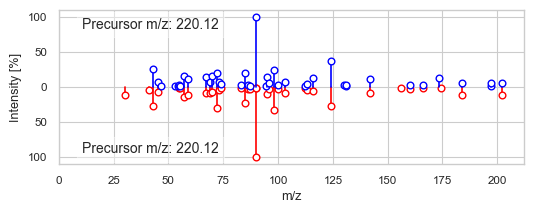

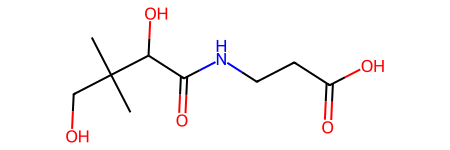


▶ Query #342 ↔ Library ID MassSpecGymID0089041 (DreaMS=0.981)


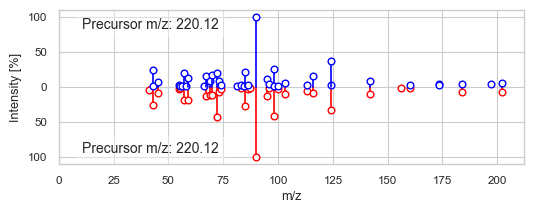

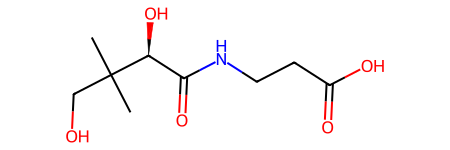


▶ Query #339 ↔ Library ID MassSpecGymID0089041 (DreaMS=0.980)


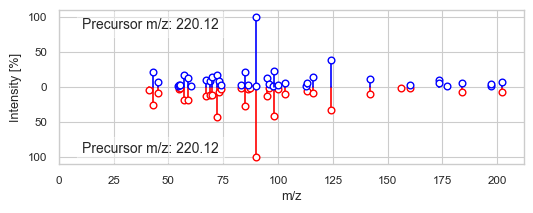

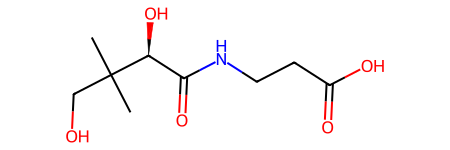


▶ Query #343 ↔ Library ID MassSpecGymID0089041 (DreaMS=0.980)


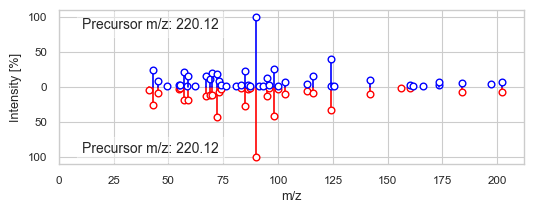

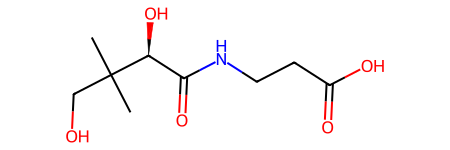


▶ Query #338 ↔ Library ID MassSpecGymID0089069 (DreaMS=0.979)


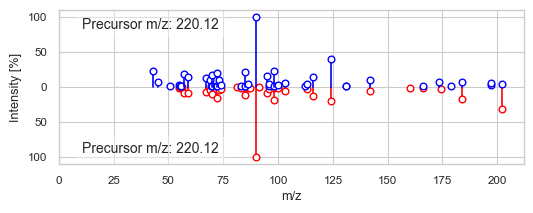

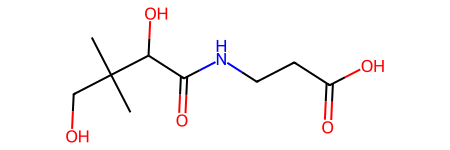


▶ Query #341 ↔ Library ID MassSpecGymID0089041 (DreaMS=0.977)


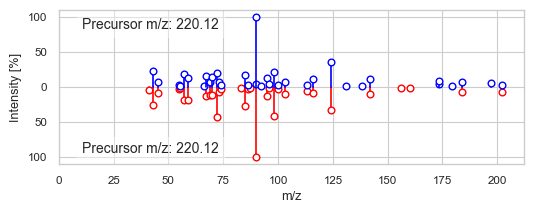

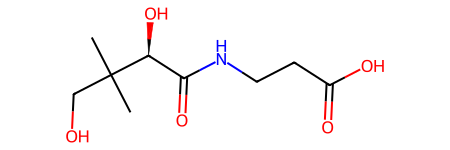


▶ Query #602 ↔ Library ID MassSpecGymID0062990 (DreaMS=0.977)


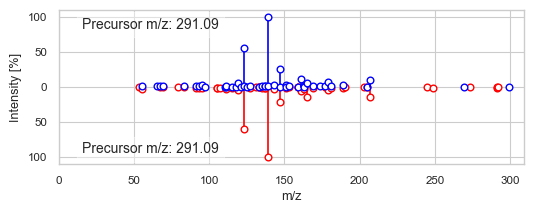

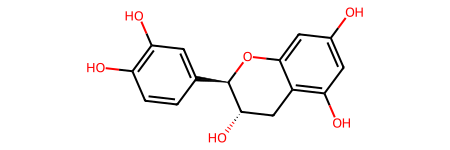


▶ Query #337 ↔ Library ID MassSpecGymID0089041 (DreaMS=0.977)


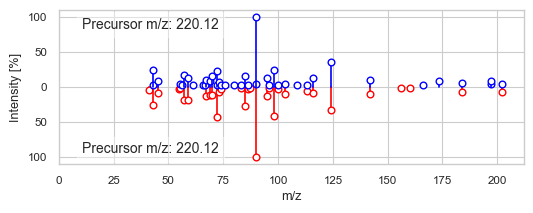

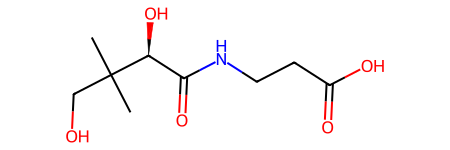


▶ Query #1632 ↔ Library ID MassSpecGymID0036861 (DreaMS=0.974)


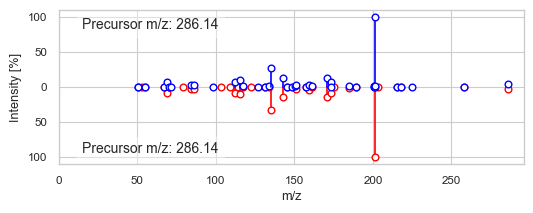

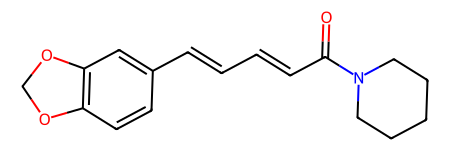


▶ Query #332 ↔ Library ID MassSpecGymID0060844 (DreaMS=0.972)


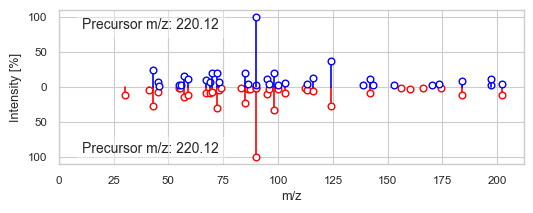

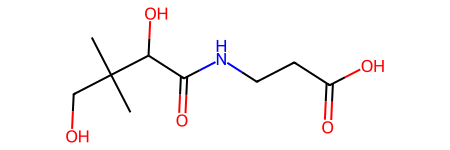

In [14]:
# 11) Mirror-plot the top-10 hits --------------------------------------------
import rdkit.Chem as Chem

for row in top10.itertuples():
    qi, li = int(row.query_index), int(row.library_index)
    print(f"\n▶ Query #{qi} ↔ Library ID {row.library_IDENTIFIER} (DreaMS={row.DreaMS_similarity:.3f})")
    su.plot_spectrum(
        spec=msdata_q.get_spectra(qi),
        mirror_spec=msdata_lib.get_spectra(li),
        prec_mz=msdata_q.get_prec_mzs(qi),
        mirror_prec_mz=msdata_lib.get_prec_mzs(li),
    )
    display(Chem.MolFromSmiles(row.library_SMILES))